In [1]:
import warnings
warnings.filterwarnings("ignore")

# Introduction

In this tutorial, we show a **minimal example of training and application of GateNet to a custom use case**.
It be divided into three steps:
1. Manual gating of few samples (+ export to .CSV)
2. Train GateNet with exported gating
3. Fully automated gating of new samples with trained GateNet

In this tutorial, manual gating is done with the very basic tool [FlowCytometryTools](https://github.com/eyurtsev/FlowCytometryTools) because it runs in Jupyter and the gates can be easily exported. More sophisticated tools like FlowJo, Kaluza etc. can also be used. Here exporting the manual gates to the required format would take some extra steps.


# 1. Manual Gating

## Explore dataset

In [2]:
import sys; sys.path.append('..')
from IPython.display import display
from fastai.basics import pd, plt, glob, torch, Path
from fastai.vision.all import get_grid
from FlowCytometryTools import FCMeasurement, PolyGate

path = '/mnt/data-ssd/cyto/fastcyto_dirs/interrater/lmd_anonym'
fpaths = pd.Series(sorted(glob.glob(f'{path}/*')))[:25]

In [3]:
panel = ['CD45-KrOrange', 'FSC']
samples = [FCMeasurement(ID=f'{i}', datafile=f) for i, f in enumerate(fpaths)]
samples = [s.transform(lambda x: x, channels=panel) for s in samples]

In [ ]:
axs = get_grid(len(samples))
for sample, ax in zip(samples, axs):
    sample.plot(panel, ax=ax)
    ax.set_title(sample.ID)
plt.tight_layout()
plt.show()

## Pick training samples

In this example, we would like to gate the **leukocytes** which is the **population in the middle** of each plot. The remaining 'rest' events (primarily bottom left) should NOT be in the gate.

**GateNet can learn with very few training examples (we will only use 5)**. To optimize results **you should pick training samples which**
- you can gate easily (minimal population overlap in 2d scatter)
- show low cell class imbalance (here samples with many 'rest' events)
- show varying batch effects (populations occur in different positions in the scatter)

Based on these criteria we pick 5 training samples which we will gate manually: 2, 3, 9, 14, 16

In [4]:
gate_name = 'leuko'
train_idxs = [2, 3, 9, 14, 16]
train_samples = [s for i, s in enumerate(samples) if i in train_idxs]

## Manual Gating

The following cell opens a widget in which one could **draw a polygon gate** and generate the respective gate polygon-coordinates for each of the train samples.

**Copy & paste the polygon-coordinates** into the "List of polygon-coordinates" cell below!

In [ ]:
for sample in train_samples:
    sample.view_interactively(backend='wx')

### List of polygon-coordinates

In [5]:
polygons = [[(2.574e+02, 1.636e+02), (1.140e+02, 6.332e+02), (1.666e+02, 1.037e+03), (8.179e+02, 1.034e+03), (7.292e+02, 1.790e+02), (2.574e+02, 1.623e+02)],
            [(2.180e+02, 1.042e+03), (2.015e+02, 4.243e+02), (3.763e+02, 1.772e+02), (8.635e+02, 1.786e+02), (8.025e+02, 1.049e+03), (2.170e+02, 1.042e+03)],
            [(1.220e+02, 1.053e+03), (9.183e+01, 5.735e+02), (4.121e+02, 4.913e+01), (8.551e+02, 4.617e+01), (7.948e+02, 1.045e+03), (1.261e+02, 1.053e+03)],
            [(3.424e+02, 1.245e+02), (2.968e+02, 1.039e+03), (7.386e+02, 1.037e+03), (6.619e+02, 1.108e+02), (3.444e+02, 1.232e+02)],
            [(3.745e+02, 4.173e+01), (2.900e+02, 1.046e+03), (8.821e+02, 1.046e+03), (8.278e+02, 5.397e+01), (3.745e+02, 4.326e+01)]]
gates = [PolyGate(p, panel, region='in', name=gate_name) for p in polygons]

## Export gates as .CSV-files

In [6]:
train_gates_path = '/mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates'
gate_fnames = fpaths.apply(lambda x: Path(x).stem + '.csv')

for i, g in zip(train_idxs, gates):
    sample_index = samples[i].get_data().index
    gate_index = samples[i].gate(g).get_data().index
    
    gate = pd.DataFrame(0, columns=['leuko'], index=sample_index)
    gate.loc[sample_index.isin(gate_index)] = 1
    
    gate.to_csv(f'{train_gates_path}/{gate_fnames[i]}', index=False)
    print(f'Gating exported to {train_gates_path}/{gate_fnames[i]}')

Gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates/02.csv
Gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates/03.csv
Gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates/09.csv
Gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates/14.csv
Gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates/16.csv


# 2. Train GateNet

## Prepare training

In [7]:
from src.train import HPARAMS, train
from src.utils import set_seed

# Fix seed for deterministic results
set_seed(seed=0)

# DataFrame with fcs- and respective labels-filepaths (exported manual gating)
df = pd.DataFrame({'fcs': fpaths, 'labels': train_gates_path + '/' + gate_fnames})
df_train = df.loc[train_idxs]

display(df_train)

# GatingDataset keyword arguments (see data/set.py for all possible kwargs)
# 'vocab' defines which cells (i.e. columns in the exported gating .CSVs) should be gated
# if 'vocab' contains 'rest', a rest class will be inferred
ds_kwargs = {'vocab': ['leuko', 'rest']}
# GateNetLoader keyword arguments (see data/loader.py for all possible kwargs)
# 'fcs_norm_stats' is a dict containing the mean and standard deviation of the fcs-markers ('fcs', 'ssc', 'cd4'...)
# 'all' sets the same mean and standard deviation for all markers
dl_kwargs = {'fcs_norm_stats': {'all': (500., 100.)}}

# Training hyperparameters ('HPARAMS' contains default parameters from the paper)
hparams = HPARAMS
# Reducing 'iters' (default 5000) for quicker test runs (but slightly lower performance)
hparams.update({'iters': 1000, 'n_context_events': 100})
print(hparams)

,fcs,labels
2,/mnt/data-ssd/cyto/fastcyto_dirs/interrater/lmd_anonym/02.LMD,/mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates/02.csv
3,/mnt/data-ssd/cyto/fastcyto_dirs/interrater/lmd_anonym/03.LMD,/mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates/03.csv
9,/mnt/data-ssd/cyto/fastcyto_dirs/interrater/lmd_anonym/09.LMD,/mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates/09.csv
14,/mnt/data-ssd/cyto/fastcyto_dirs/interrater/lmd_anonym/14.LMD,/mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates/14.csv
16,/mnt/data-ssd/cyto/fastcyto_dirs/interrater/lmd_anonym/16.LMD,/mnt/data-ssd/cyto/fastcyto_dirs/interrater/train_gates/16.csv


{'iters': 1000, 'iters_min': 50, 'epochs_max': 10, 'lr': 0.002, 'bs': 1024, 'gamma': 5, 'beta': 0.99, 'n_filter': (1024, 512, 256), 'n_filter_context': (64, 48), 'n_head_nodes': (32,), 'balance_ids': False, 'oversample_beta': 0.999, 'n_context_events': 100}


# GateNet





## Model training

In [8]:
learner = train(df_train, df_train.iloc[:1], hparams, ds_kwargs=ds_kwargs, dl_kwargs=dl_kwargs)

In [9]:
torch.save(learner.model.state_dict(), model_path := 'gatenet.pt')

# 3. Fully automated gating

## GateNet prediction

In [10]:
from src.predict import predict

result = predict('gatenet.pt', df[['fcs']], hparams, ds_kwargs, dl_kwargs, progress_bar=True)
print(f'{len(df)} samples gated successfully ({len(result)} events in total)')

auto_gates_path = '/mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates'

for i, (_, fresult) in enumerate(result.groupby('id')):
    gate = fresult[gate_name].to_frame(gate_name)
    gate.to_csv(f'{auto_gates_path}/{gate_fnames[i]}', index=False)
    print(f'Automatic gating exported to {auto_gates_path}/{gate_fnames[i]}')
    

25 samples gated successfully (3065912 events in total)
Automatic gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates/00.csv
Automatic gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates/01.csv
Automatic gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates/02.csv
Automatic gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates/03.csv
Automatic gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates/04.csv
Automatic gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates/05.csv
Automatic gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates/06.csv
Automatic gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates/07.csv
Automatic gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates/08.csv
Automatic gating exported to /mnt/data-ssd/cyto/fastcyto_dirs/interrater/auto_gates/09.csv
Automatic gating exported to /mnt/

## Visualize results

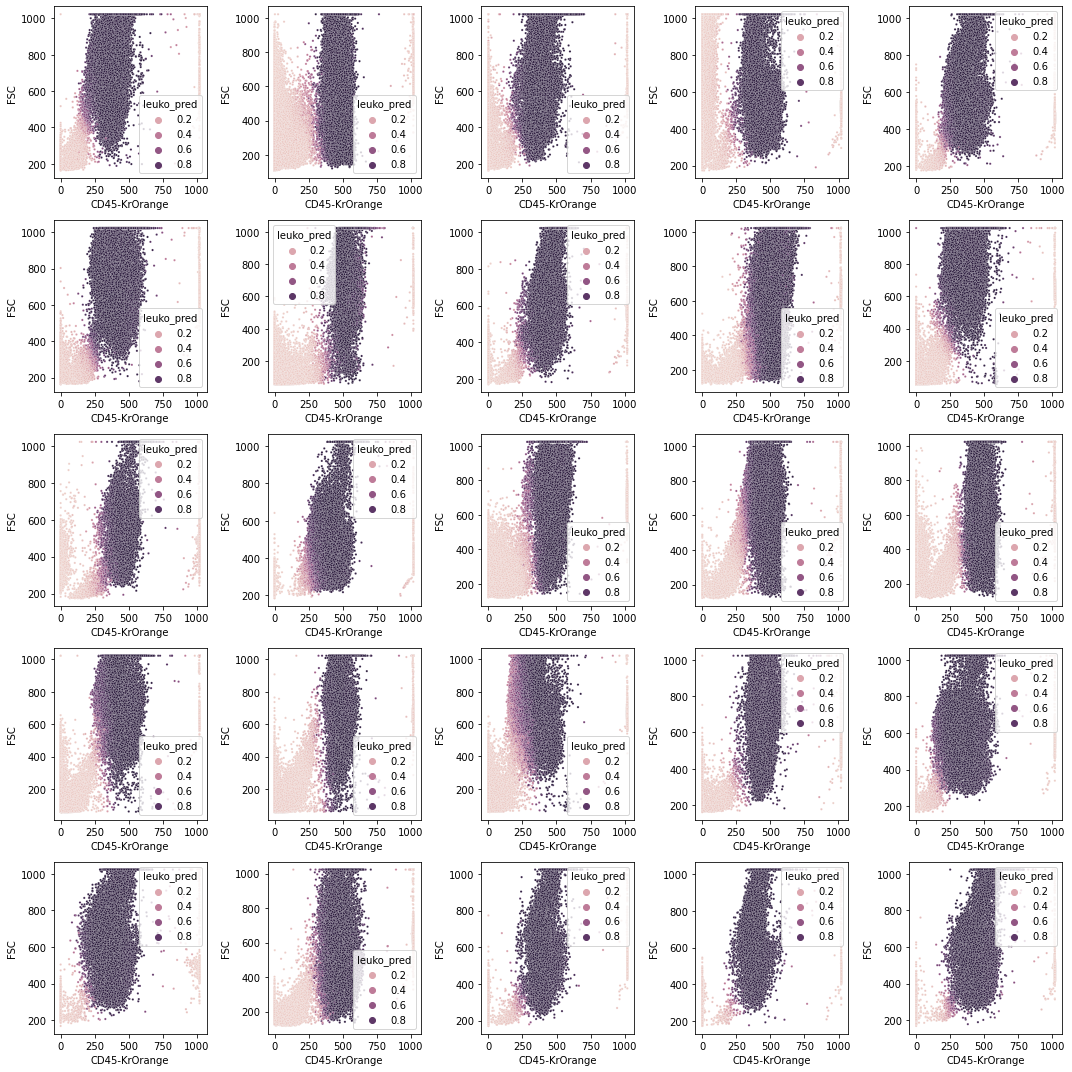

In [11]:
import seaborn as sn

show_probabilities = True

axs = get_grid(len(df))
for i, (_, fresult) in enumerate(result.groupby('id')):
    sn.scatterplot(data=fresult, x=panel[0], y=panel[1], hue=f'{gate_name}_pred', s=5, ax=axs[i])

plt.tight_layout()
plt.show()